In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import random
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

import data_model
import fine_time_coupling_model
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Data generator

#### Poisson

In [10]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
lmbd_0, lmbd_1, lmbd_2 = 20, 20, 20
trial_length, num_trials = 2, 500
trial_window = [0, trial_length]
generator_par = None
spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials)
spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials)
spike_times_z = generator.generate_poisson_spike_times(lmbd_2, trial_length, num_trials)

#### Hawkes process

In [114]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 500, 'random_seed': None,
    'type': 'square', 'mu': [20., 20., 20], 'num_nodes': 3, 
    'alpha': [[0.0,0.0,5.0], [0.0,0.0,5.0], [0.0,0.0,0.0]], 'beta': [[0.05,0.05,0.05], [0.05,0.05,0.05], [1.0,1.0,1.0]]}
spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[2]
spike_times_y = spike_times[1]
spike_times_z = spike_times[0]

lambda stable: [25. 25. 20.]
Gamma
[[0.   0.   0.25]
 [0.   0.   0.25]
 [0.   0.   0.  ]]
100%|█████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.78it/s]


#### Amarasingham data.

In [ ]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(2)
trial_length = 2
num_peaks = 30
baseline = 10
num_trials = 250
sigma = 0.04

file_path = project_dir + 'Output/fig/eg_amarasingham_data.pdf'
spike_times = generator.generate_amarasingham_example_spike_times(num_peaks, sigma, trial_length, num_trials*2, 
        baseline, sample_type='density', verbose=2, file_path=None)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]

#### Amarasingham + coupling filter.

x --> z,   y--> z

In [15]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': 100, 'baseline': 10, 'sigma': 0.04, 'random_seed': 6, 
    'type': 'square', 'num_nodes': 3,
    'alpha': [[0.,10,10], [0.0,0.0,0.0], [0.0,0.0,0.0]], 'beta': [[1.0,0.05,0.05], [1.0,1.0,0.05], [1.0,1.0,1.0]]}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[2]
spike_times_y = spike_times[1]
spike_times_z = spike_times[0]

lambda_max (proposal): 509.41
lambda stable: [127.35  63.68  63.68]
100%|█████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


z --> x, z --> y

In [19]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': 100, 'baseline': 10, 'sigma': 0.04, 'random_seed': 6, 
    'type': 'square', 'num_nodes': 3,
    'alpha': [[0.,0.,0.], [10.,0.,0.], [10.,0.,0.]], 'beta': [[0.,0.,0.], [.05,0.,0.], [.05,0.,0.]]}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[2]
spike_times_y = spike_times[1]
spike_times_z = spike_times[0]

lambda_max (proposal): 509.41
lambda stable: [63.68 95.51 95.51]
100%|█████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


##### very strong coupling 0,1,2,3 --> 4,5

In [340]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
# Inject spike trains. (can introduce coupling effects)
alpha = np.zeros([6,6]); alpha[-1,:4] = 15; alpha[-2,:4] = 15
beta = np.zeros([6,6]); beta[-1,:4] = 0.01; beta[-2,:4] = 0.01

# model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 20, 'mu':20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

# model_name = 'nobackground_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 0, 'mu':0, 'baseline': 20, 'window': 'gaussian', 'sigma': 1, 'random_seed': 2, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

alpha = np.zeros([6,6]);
beta = np.zeros([6,6]); beta[-1,:4] = 0.01; beta[-2,:4] = 0.01
model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
        f'alpha{0}_sigma_100ms_trials{100}_nonrepeated'
generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu':30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
    'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)

100%|█████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


##### normal coupling 0,1,2,3 --> 4,5    4 --> 5

In [ ]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
num_trials = 300
# Inject spike trains. (can introduce coupling effects)
alpha = np.zeros([6,6]); alpha[5,[0,1,2,3]] = -3; alpha[4,[0,1,2,3]] = 2; alpha[-2,-1]=2
beta = np.zeros([6,6]) + 0.03;

# model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 20, 'mu':20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

# model_name = 'nobackground_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 0, 'mu':0, 'baseline': 20, 'window': 'gaussian', 'sigma': 1, 'random_seed': 2, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

model_name = f'poisson_background_gaussian_mixture_multivariate_alpha{0}_sigma_100ms_trials{num_trials}_nonrepeated'
generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu':20, 'baseline': 15, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
    'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)


##### Load data

In [11]:
data_dir = project_dir + 'Output/jitter/multivariate_coupling_data/'
file_path = data_dir + 'poisson_background_gaussian_mixture_square_spike_driveralpha15_beta10ms_sigma_100ms_trials100_nonrepeated_generator_par.pkl'
generator_par = util.load_variable(file_path)
file_path = data_dir + 'poisson_background_gaussian_mixture_square_spike_driveralpha15_beta10ms_sigma_100ms_trials100_nonrepeated_itr0.pkl'
spike_times = util.load_variable(file_path)

trial_length = generator_par['trial_length']
trial_window = generator_par['trial_window']

# file_path = data_dir + 'poisson_background_gaussian_mixture_square_spike_driveralpha0_sigma_100ms_trials100_nonrepeated_generator_par.pkl'
# generator_par = util.load_variable(file_path)
# file_path = data_dir + 'poisson_background_gaussian_mixture_square_spike_driveralpha0_sigma_100ms_trials100_nonrepeated_itr0.pkl'
# spike_times = util.load_variable(file_path)

In [5]:
spike_times_x0 = spike_times[0]
spike_times_x1 = spike_times[1]
spike_times_x2 = spike_times[2]
spike_times_x3 = spike_times[3]
spike_times_x4 = spike_times[4]
spike_times_x5 = spike_times[5]

##### Save data.

In [341]:
data_dir = project_dir + 'Output/jitter/multivariate_coupling_data/'

file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)
file_path = data_dir + model_name + f'_itr{0}.pkl'
util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/multivariate_coupling_data/poisson_background_gaussian_mixture_square_spike_driveralpha0_sigma_100ms_trials100_nonrepeated_generator_par.pkl


#### Check data statistics.

layers 3, nodes 6, trials 50
meanFR [40.068 40.088 39.964 39.164 48.924 34.296]	meanISI [40.514 40.494 40.261 39.509 49.451 34.699]


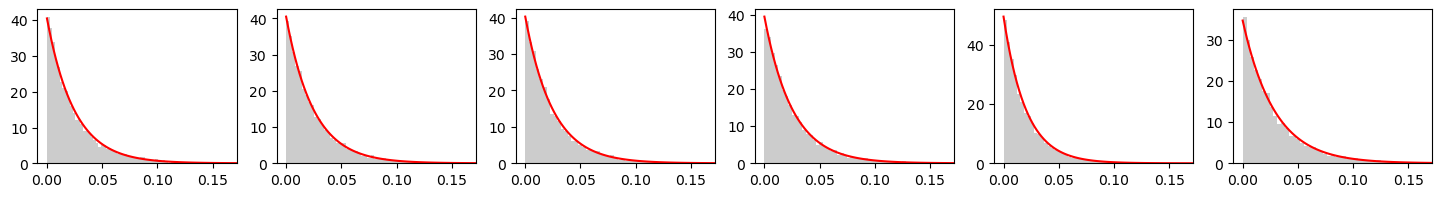

layers 3, nodes 6, trials 50


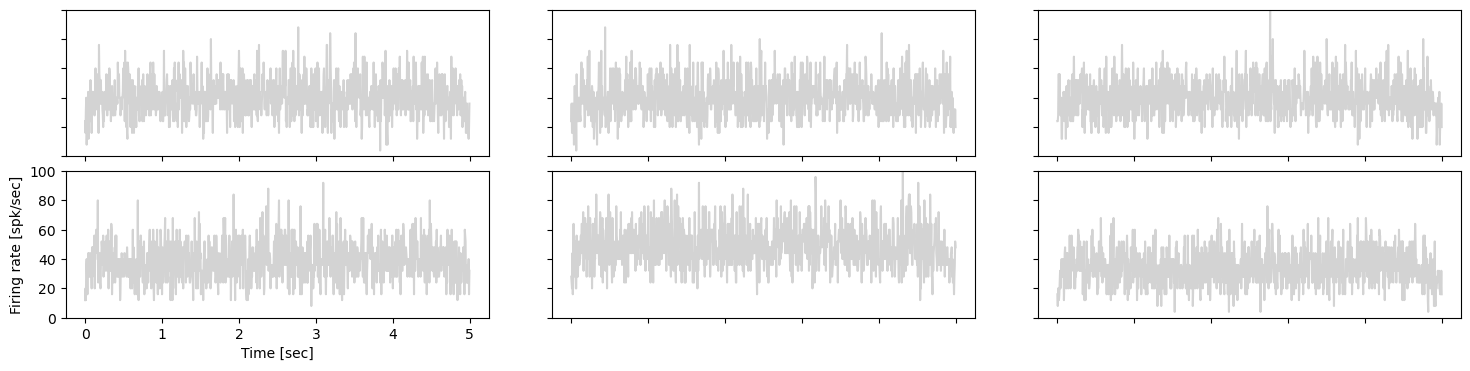

In [15]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=1)
_=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
# generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, node_ids=[0,1], trial_ids=[0], plot_window=[0, 0.5], ylim=[None, None])

#### Kernel width plug-in estimator.

optimal kernel width  120.0


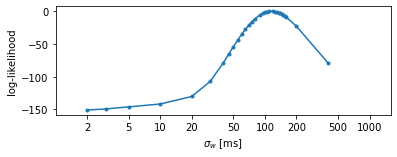

In [351]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
kernel_widths_sim0, log_likeli_hat0 = jittertool.estimate_optimal_jitter_window_width(spike_times_x4, spike_times_x5, model_par)

optimal kernel width  110.0


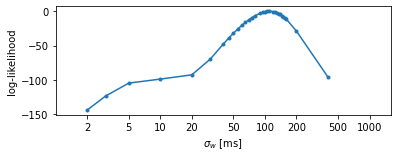

In [362]:
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
kernel_widths_sim1, log_likeli_hat1 = jittertool.estimate_optimal_jitter_window_width(spike_times_x4, spike_times_x5, model_par)

num_curves 2
save figure: D:/Brain_Network/Output/fig/log_likelihood_curves_compare_with_without_fastcomponents.pdf


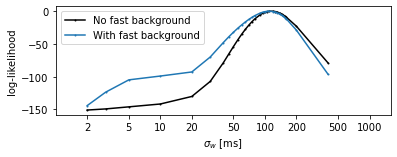

In [369]:
file_path = project_dir + 'Output/fig/log_likelihood_curves_compare_with_without_fastcomponents.pdf'
kernel_widths_list = [kernel_widths_sim0, kernel_widths_sim1]
log_likeli_hat_list = [log_likeli_hat0, log_likeli_hat1]
jittertool.plot_multiple_plugin_estimator_likelihood_curves(kernel_widths_list, log_likeli_hat_list, file_path=file_path)

# Bivariate nuisance regression.
Coupling filter does not strongly introduce the transitivity, as the consequency is too weak.

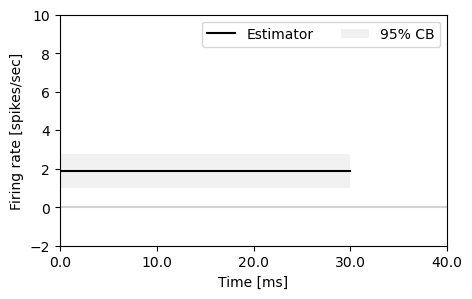

In [35]:
jittertool = jitter.JitterTool()
model_par_bspline = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.1, 'filter_length': 0.04, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.12,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times[1], spike_times[4], trial_window, model_par_square)

file_path = project_dir + 'Output/fig/driver_network_alpha15_beta10ms_rho20_kernel5ms_bivariate_reg.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, xlim=[0,0.04], ylim=[-2, 10], file_path=None)

In [322]:
file_path = project_dir + f'Output/jitter/multivariate_coupling_model/{model_name}_kernel{5}ms_bivariate_model_par.pkl'
# util.save_variable(file_path, model_par_hat4)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/multivariate_coupling_model/nobackground_square_spike_driveralpha15_beta10ms_sigma_100ms_trials100_nonrepeated_kernel5ms_bivariate_model_par.pkl


# Multivariate nuisance regression.

In [304]:
jittertool = jitter.JitterTool()

model_par_const = {'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_square0 = {'filter_type': 'square', 'filter_length': 0.01,
             'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_bspline = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.2, 'filter_length': 0.04, 'num_tail_drop': 1,
             'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_hat_multi = jittertool.multivariate_continuous_time_coupling_filter_regression(
    [[], 
     spike_times_x0,spike_times_x1,spike_times_x2,spike_times_x3,spike_times_x4], 
    spike_times_x5,
    trial_window, 
    [model_par_const,
     model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),model_par_square0.copy(),
     model_par_bspline,])

# model_par_hat = jittertool.multivariate_continuous_time_coupling_filter_regression(
#     [[], spike_times_x4], spike_times_x5,
#     trial_window, [model_par_const,model_par_bspline,])

In [305]:
model_dir = project_dir + 'Output/jitter/multivariate_coupling_model/'
model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
        f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
file_path = model_dir + f'{model_name}_kernel{100}ms_multivariate_model_par.pkl'
util.save_variable(file_path, model_par_hat_multi)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/multivariate_coupling_model/poisson_background_gaussian_mixture_square_spike_driveralpha15_beta10ms_sigma_100ms_trials100_nonrepeated_kernel100ms_multivariate_model_par.pkl


filter integral [-0.00522493]
save figure: D:/Brain_Network/Output/fig/driver_network_alpha15_beta10ms_rho20_multivariate_reg.pdf


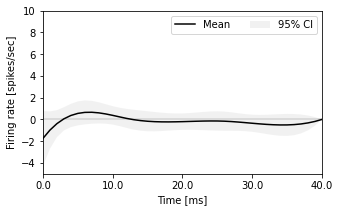

In [306]:
file_path = project_dir + 'Output/fig/driver_network_alpha15_beta10ms_rho20_multivariate_reg.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat[-1], xlim=[0,0.04], ylim=[-5, 10], file_path=file_path)

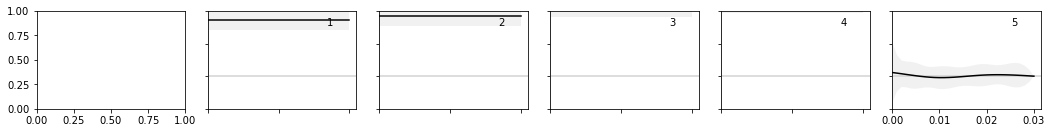

In [155]:
file_path = project_dir + 'Output/fig/xxx.pdf'
jittertool.plot_continuous_time_multivariate_regression_model_par(model_par_hat, generator_par, ylim=[-5, 10], file_path=None)

# Jitter CCG.

100%|█████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.46it/s]


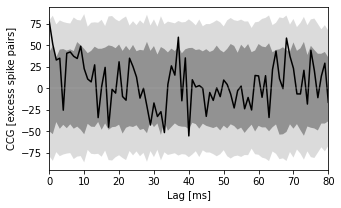

In [161]:
jittertool = jitter.JitterTool()
spk_bin_width = 0.001
lag_range = [0, 0.08]
jitter_window_width = 0.1
distribution_type='mc_sim'
num_jitter = 200
file_path = project_dir + 'Output/fig/eg_amarasingham_square_filter_weak_ccg_spk5ms_jitterwindow120ms.pdf'
ret_vals = jittertool.cross_correlation_jitter(spike_times_x4, spike_times_x5, spk_bin_width, trial_length, lag_range, jitter_window_width,
    distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.05, verbose=True, file_path=None)

# Jitter correction for coupling filters

In [165]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1, 
             'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 10, 'jitter_window_width': 0.12, 
             'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'square', 'filter_length': 0.04,
#              'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 10, 'jitter_window_width': 0.12,
#              'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_raw, model_par_jitter = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
    spike_times_x, spike_times_y, trial_window, model_par, verbose=True)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]


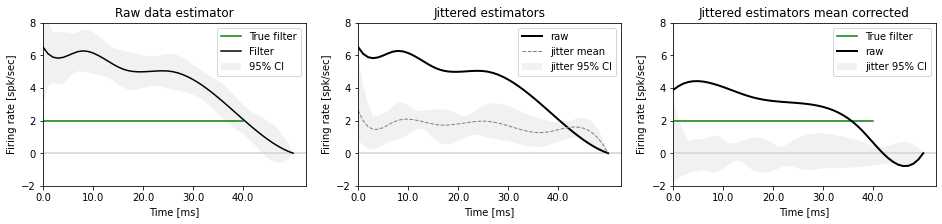

In [166]:
file_path = project_dir + 'Output/fig/eg_amarasingham_negsquare_filter_jitter_regression_jitterwindow120ms.pdf'
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter,
    generator_par, ylim=[-2, 8], file_path=None)